In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
import pickle
import seaborn as sns
import multiprocessing
import re
from importlib import reload

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/cper_hls_veg_models/biomass/params')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')

In [3]:
#reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *

In [4]:
#reload(sys.modules["hpc_setup"])
from hpc_setup import launch_dask
from ml_setup import fit_ols, fit_dnn

In [6]:
#client.cluster.close()
#client.close()

In [7]:
if backend == 'dask':
    from hpc_setup import launch_dask
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=32
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='atlas', 
                         duration='04:00:00',
                         slurm_opts={'interface': interface},
                          extra_directives=["--account=cper_neon_aop"],
                        wait_timeout=300,
                        debug=False)
    display(client)
    nthreads = len(client.nthreads())
else:
    nthreads = multiprocessing.cpu_count()

ib0
   setting up cluster on HPC...


<Client: 'tcp://172.21.15.135:36923' processes=0 threads=0, memory=0 B>

In [5]:
import torch
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [6]:
#reload(sys.modules["ml_setup"])
from ml_setup import make_model_dictionary
from ml_setup import run_ml_models

In [7]:
import random
import re

In [8]:
dist_facts = [0, 99, 95, 85, 75, 50, 10]
rand_seeds = list(np.arange(120, 127))

In [12]:
for idx_d, dist_fact in enumerate(dist_facts):
    reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
    from cper_bm_params_fit_kmeans_transect import *
    mod_dict = make_model_dictionary(var_names, y_col, device)
    df, centroid, scores, label = load_df(inPATH, ['Date', 'Date_mean'])
    df = df.reset_index(drop=True)
    if dist_fact != 0:
        print('Running using Kmeans clusters resampled with random distance factor of ' + str(dist_fact))
        kfold_group = kfold_group + '_r' + str(dist_fact)
        tuneby_group = tuneby_group + '_r' + str(dist_fact)

        outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv', inFILE))
        
        centroid_idxs = list(range(centroid.shape[0]))
        
        rand_idxs = []
        rand_labels = []
        
        df['kfold_rand'] = ''
        random.seed(rand_seeds[idx_d].item())
        random.shuffle(centroid_idxs)
        for idx, i in enumerate(centroid_idxs):
            if idx < (centroid.shape[0] - 1):
                centroid_dists = np.sum((centroid - centroid[i])**2, axis=1)
                centroid_dists_avail = centroid_dists[np.arange(len(centroid_dists))!=i]
                centroid_dists_wtd = list(centroid_dists_avail/sum(centroid_dists_avail) * (100-dist_fact))
                centroid_dists_wtd.insert(i, dist_fact)
                centroid_dists_wtd = np.array(centroid_dists_wtd)
                
                #point = centroid[i].astype(float)
                #other_points = df.loc[[x for x in df.index if x not in rand_idxs]][var_names].values.astype(float)
                #other_points = df_plot_scores.loc[[x for x in df_plot_scores.index if x not in rand_idxs], 
                #[x for x in df_plot_scores.columns if 'PC' in x]]
                #ec_wdistances = np.sum((other_points - point) ** dist_fact, axis=1)
                avail_idxs = [x for x in df.index if x not in rand_idxs]
                #rand_idxs_i = np.random.choice(avail_idxs, size=len(df_plot_scores)//10, replace=False, p=ec_wdistances/sum(ec_wdistances))
                probs = [centroid_dists_wtd[label_i] for label_i in label[avail_idxs]]
                rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, 
                                               p=probs/sum(probs))
                rand_idxs.extend(rand_idxs_i)
                df.loc[rand_idxs_i, 'kfold_rand'] = str(i)
            else:
                df.loc[df['kfold_rand'] == '', 'kfold_rand'] = str(i)

        #df = pd.merge(df, df_plot_scores[['Plot', 'Date_mean', 'kfold_rand']], how='left', on=['Plot', 'Date_mean'])
        
        df[kfold_group] = df['kfold_rand']
        
        df['Kmeans_distfact'] = dist_fact
        
        df = df.drop(columns='kfold_rand')
    else:
        print('Running using Kmeans clusters')
    
    mod_dict['DNN']['fit'] = False
    if prefix == 'transect':
        mod_dict['DNN']['param_grid']['batch_size'] =  [256]
    
    if 'BAI_236' not in var_names or 'NDII7' not in var_names or 'NIR1' not in var_names:
        mod_dict['CPER_2022']['fit'] = False
        mod_dict['OLS_2022']['fit'] = False
    
    #for k in mod_dict.keys():
    #    if k not in ['SVR', 'HGBR']:
    #        mod_dict[k]['fit'] = False
    
    mod_dict['GBR']['fit'] = False
    mod_dict['HGBR']['variable_importance'] = True
    
    run_ml_models(nickname,
                 mod_dict,
                 df, 
                 y_col,
                 date_col,
                 var_names,
                 kfold_group,
                 tuneby_group, 
                 kfold_type,
                 tune_kfold_type,
                 outFILE_tmp, 
                 outDIR,
                 backend,
                 nthreads,
                 cper_mod_xfrm,
                 cper_mod_xfrm_func,
                 client)

Running using Kmeans clusters
0
....fitting CPER_2022 (time to fit: 0.2 secs)
....fitting OLS_2022 (time to fit: 0.21 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 32.0 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.675e+04, tolerance: 7.353e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 61.01 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.72 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 1.64 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 3.65 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 52.51 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 10.3 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.04 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.28 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.264e+04, tolerance: 6.947e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.64 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.78 secs)
....fitting SVR (time to fit: 2.82 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 14.49 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.07 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.28 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.3 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 13.54 secs)
....fitting PLS (time to fit: 0.59 secs)
....fitting PCR (time to fit: 0.84 secs)
....fitting SVR (time to fit: 2.72 secs)
....fitting RF (time to fit: 51.77 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.78 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.9 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 26.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 26.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.562e+04, tolerance: 7.442e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.16 secs)
....fitting PLS (time to fit: 0.59 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.11 secs)
....fitting RF (time to fit: 50.5 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.14 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.15 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.953e+04, tolerance: 7.518e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.36 secs)
....fitting PLS (time to fit: 1.0 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.48 secs)
....fitting RF (time to fit: 55.26 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.89 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.12 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.607e+04, tolerance: 5.984e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.44 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 1.19 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.34 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 11.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.2 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.0 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.16 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.160e+04, tolerance: 6.322e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.92 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 1.21 secs)
....fitting SVR (time to fit: 2.82 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 14.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 50.76 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.9 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.04 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 25.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 25.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 12.06 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.73 secs)
....fitting SVR (time to fit: 2.89 secs)
....fitting RF (time to fit: 51.87 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.77 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.17 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 29.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 28.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 14.44 secs)
....fitting PLS (time to fit: 0.8 secs)
....fitting PCR (time to fit: 0.73 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.51 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 10.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.27 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.45 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 13.97 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 26.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 26.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.353e+04, tolerance: 7.342e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.7 secs)
....fitting PLS (time to fit: 0.54 secs)
....fitting PCR (time to fit: 0.71 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.02 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 13.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.74 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.02 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 99
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 13.58 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.570e+04, tolerance: 7.285e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 19.34 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.6 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.73 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 4.18 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 53.9 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.47 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.25 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.944e+04, tolerance: 6.927e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.79 secs)
....fitting PLS (time to fit: 0.56 secs)
....fitting PCR (time to fit: 1.28 secs)
....fitting SVR (time to fit: 2.76 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.17 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.04 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.22 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.762e+04, tolerance: 7.362e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.88 secs)
....fitting PLS (time to fit: 0.64 secs)
....fitting PCR (time to fit: 0.77 secs)
....fitting SVR (time to fit: 2.57 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 57.56 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.46 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.15 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.673e+04, tolerance: 7.439e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.91 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.82 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.03 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.55 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.13 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.11 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.896e+04, tolerance: 7.323e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 17.83 secs)
....fitting PLS (time to fit: 1.08 secs)
....fitting PCR (time to fit: 0.94 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.1 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.88 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.14 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.21 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.09 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.545e+04, tolerance: 6.112e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.46 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.72 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.92 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.48 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.96 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.94 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.310e+04, tolerance: 6.583e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.4 secs)
....fitting PLS (time to fit: 0.72 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.2 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.05 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.14 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.14 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.811e+04, tolerance: 6.965e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.27 secs)
....fitting PLS (time to fit: 0.58 secs)
....fitting PCR (time to fit: 0.79 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.11 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 58.56 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.83 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.02 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.195e+04, tolerance: 5.229e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 17.76 secs)
....fitting PLS (time to fit: 1.14 secs)
....fitting PCR (time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.38 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.86 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.41 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.03 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.504e+04, tolerance: 7.411e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.4 secs)
....fitting PLS (time to fit: 0.67 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.19 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.4 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.29 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 95
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 13.87 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.458e+04, tolerance: 7.193e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 19.43 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.56 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 4.11 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 52.2 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.76 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.36 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.036e+04, tolerance: 6.679e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.04 secs)
....fitting PLS (time to fit: 0.8 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.19 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.51 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.97 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.05 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.650e+04, tolerance: 7.269e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.13 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 1.38 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.43 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 11.47 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 61.21 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.84 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.04 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.585e+04, tolerance: 7.439e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.74 secs)
....fitting PLS (time to fit: 0.55 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR (time to fit: 2.57 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 57.78 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.71 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.1 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.065e+04, tolerance: 6.831e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.77 secs)
....fitting PLS (time to fit: 0.63 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.24 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 62.84 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.86 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.2 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.988e+04, tolerance: 5.904e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.25 secs)
....fitting PLS (time to fit: 0.61 secs)
....fitting PCR (time to fit: 0.73 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.35 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.69 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.01 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.09 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+04, tolerance: 6.347e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.74 secs)
....fitting PLS (time to fit: 0.61 secs)
....fitting PCR (time to fit: 0.73 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.59 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.43 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.36 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.17 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.591e+04, tolerance: 6.937e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.78 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.17 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 57.38 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.01 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.95 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.145e+04, tolerance: 6.732e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.65 secs)
....fitting PLS (time to fit: 0.63 secs)
....fitting PCR (time to fit: 0.79 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.12 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.93 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.85 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.96 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.404e+04, tolerance: 7.322e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.37 secs)
....fitting PLS (time to fit: 1.26 secs)
....fitting PCR (time to fit: 0.72 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.19 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.88 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 51.29 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.92 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 85
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 13.94 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.437e+04, tolerance: 7.299e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 19.27 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.6 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 1.35 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 3.2 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 58.48 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.52 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.95 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.902e+04, tolerance: 6.939e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.82 secs)
....fitting PLS (time to fit: 0.55 secs)
....fitting PCR (time to fit: 0.67 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.03 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.48 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.0 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.91 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.692e+04, tolerance: 7.315e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.67 secs)
....fitting PLS (time to fit: 0.76 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.02 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.52 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.14 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.9 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.748e+04, tolerance: 7.414e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.04 secs)
....fitting PLS (time to fit: 1.04 secs)
....fitting PCR (time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.22 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.08 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.05 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.86 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.478e+04, tolerance: 7.339e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.75 secs)
....fitting PLS (time to fit: 0.58 secs)
....fitting PCR (time to fit: 0.81 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.19 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.97 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.12 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.03 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.412e+04, tolerance: 6.153e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.93 secs)
....fitting PLS (time to fit: 0.69 secs)
....fitting PCR (time to fit: 0.71 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.19 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.45 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.99 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.95 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.427e+04, tolerance: 6.513e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.12 secs)
....fitting PLS (time to fit: 1.71 secs)
....fitting PCR (time to fit: 1.01 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.2 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 50.76 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.04 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.07 secs)
....fitting OLS_2022 (time to fit: 0.1 secs)
....fitting OLS (time to fit: 13.88 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.610e+04, tolerance: 6.925e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.7 secs)
....fitting PLS (time to fit: 0.63 secs)
....fitting PCR (time to fit: 3.7 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.36 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 10.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 59.17 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.58 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.03 secs)
....fitting OLS_2022 (time to fit: 0.11 secs)
....fitting OLS (time to fit: 14.0 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.606e+04, tolerance: 5.373e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.69 secs)
....fitting PLS (time to fit: 0.58 secs)
....fitting PCR (time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.04 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 57.97 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.79 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.87 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.564e+04, tolerance: 7.376e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.82 secs)
....fitting PLS (time to fit: 0.61 secs)
....fitting PCR (time to fit: 0.71 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.96 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.4 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.35 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 75
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 14.23 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.320e+04, tolerance: 7.028e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 18.91 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.59 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.73 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 3.28 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 53.91 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.9 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.92 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.903e+04, tolerance: 6.824e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.11 secs)
....fitting PLS (time to fit: 0.57 secs)
....fitting PCR (time to fit: 1.15 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.2 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.93 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.31 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.04 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.540e+04, tolerance: 7.071e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.11 secs)
....fitting PLS (time to fit: 0.87 secs)
....fitting PCR (time to fit: 1.01 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.99 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.78 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.07 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.09 secs)
....fitting OLS (time to fit: 13.4 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.566e+04, tolerance: 7.208e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.09 secs)
....fitting PLS (time to fit: 0.58 secs)
....fitting PCR (time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.24 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.29 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 7.95 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 13.91 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.786e+04, tolerance: 7.267e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.97 secs)
....fitting PLS (time to fit: 1.06 secs)
....fitting PCR (time to fit: 0.72 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.13 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.64 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.2 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.01 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.208e+04, tolerance: 6.038e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.06 secs)
....fitting PLS (time to fit: 0.61 secs)
....fitting PCR (time to fit: 0.75 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.24 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.79 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.63 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.05 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.226e+04, tolerance: 6.519e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.13 secs)
....fitting PLS (time to fit: 0.69 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.09 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 20.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.1 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.1 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.43 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.383e+04, tolerance: 6.876e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.22 secs)
....fitting PLS (time to fit: 0.57 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.04 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 57.75 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.67 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.14 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.381e+04, tolerance: 6.785e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.47 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 0.75 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.17 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 59.8 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.16 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.99 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.410e+04, tolerance: 7.122e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.58 secs)
....fitting PLS (time to fit: 0.75 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.31 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.79 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.4 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.71 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 50
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 13.96 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.284e+04, tolerance: 6.938e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 18.56 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.57 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.77 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 3.4 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 51.02 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.1 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.93 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.849e+04, tolerance: 6.847e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.1 secs)
....fitting PLS (time to fit: 0.73 secs)
....fitting PCR (time to fit: 0.68 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.22 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.73 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.19 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 13.97 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.537e+04, tolerance: 6.951e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.41 secs)
....fitting PLS (time to fit: 1.22 secs)
....fitting PCR (time to fit: 1.23 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.5 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 51.78 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.42 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.03 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.994e+04, tolerance: 7.313e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.21 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.76 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.12 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.18 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.32 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.15 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.436e+04, tolerance: 7.187e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.84 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 0.77 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.11 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.0 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.55 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.05 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.385e+04, tolerance: 6.597e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.92 secs)
....fitting PLS (time to fit: 1.11 secs)
....fitting PCR (time to fit: 0.74 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.55 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.93 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.48 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.01 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.525e+04, tolerance: 6.637e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.94 secs)
....fitting PLS (time to fit: 0.6 secs)
....fitting PCR (time to fit: 0.93 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.3 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 52.81 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.02 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.25 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.598e+04, tolerance: 6.963e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.64 secs)
....fitting PLS (time to fit: 0.65 secs)
....fitting PCR (time to fit: 0.75 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.24 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.06 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.88 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
8
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.28 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.153e+04, tolerance: 6.088e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.46 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 0.83 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.29 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.64 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.69 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.07 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.773e+04, tolerance: 7.328e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.48 secs)
....fitting PLS (time to fit: 0.61 secs)
....fitting PCR (time to fit: 1.28 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.03 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.31 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.46 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running using Kmeans clusters resampled with random distance factor of 10
0
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:585: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])


(time to fit: 14.86 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.739e+04, tolerance: 7.228e+01
  model = cd_fast.enet_coordinate_descent(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:671: FutureWarning: The behavior of DataFrame concatenatio

(time to fit: 19.03 secs)
....fitting PLS 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:692: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.59 secs)
....fitting PCR 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:703: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 0.96 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:708: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 5.2 secs)
....fitting RF 

/project/cper_neon_aop/hls_nrt/fit/ml_setup.py:714: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],


(time to fit: 51.17 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.44 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
1
....fitting CPER_2022 (time to fit: 0.03 secs)
....fitting OLS_2022 (time to fit: 0.08 secs)
....fitting OLS (time to fit: 14.24 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.799e+04, tolerance: 7.066e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.81 secs)
....fitting PLS (time to fit: 0.62 secs)
....fitting PCR (time to fit: 0.87 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 4.09 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.43 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.44 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
2
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.35 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.825e+04, tolerance: 6.145e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.73 secs)
....fitting PLS (time to fit: 1.11 secs)
....fitting PCR (time to fit: 0.77 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.51 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 61.99 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.6 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
3
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.14 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.271e+04, tolerance: 6.740e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.11 secs)
....fitting PLS (time to fit: 0.79 secs)
....fitting PCR (time to fit: 0.95 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.23 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.81 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.09 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
4
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.04 secs)
....fitting OLS (time to fit: 14.14 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.159e+04, tolerance: 6.446e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.32 secs)
....fitting PLS (time to fit: 0.83 secs)
....fitting PCR (time to fit: 0.83 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.18 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.24 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.83 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
5
....fitting CPER_2022 (time to fit: 0.03 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.49 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.479e+04, tolerance: 6.913e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.1 secs)
....fitting PLS (time to fit: 0.65 secs)
....fitting PCR (time to fit: 0.8 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.49 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 18.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 56.34 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.69 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
6
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.18 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.567e+04, tolerance: 6.938e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.77 secs)
....fitting PLS (time to fit: 0.64 secs)
....fitting PCR (time to fit: 0.72 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.64 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 53.89 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.95 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
7
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.25 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.75 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.425e+04, tolerance: 7.070e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 19.29 secs)
....fitting PLS (time to fit: 1.12 secs)
....fitting PCR (time to fit: 0.83 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.27 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 55.2 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 8.84 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
9
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.03 secs)
....fitting OLS (time to fit: 14.15 secs)
....fitting LASSO 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 27.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.683e+04, tolerance: 7.366e+01
  model = cd_fast.enet_coordinate_descent(


(time to fit: 18.87 secs)
....fitting PLS (time to fit: 2.02 secs)
....fitting PCR (time to fit: 0.84 secs)
....fitting SVR 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(time to fit: 3.23 secs)
....fitting RF 

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 19.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(time to fit: 54.16 secs)
Skipping GBR, params not set to fit.
....fitting HGBR (time to fit: 9.02 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.


In [9]:
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *

In [11]:
from scipy.stats import hmean

In [22]:
dist_fact = 99
idx_d = 1
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *
mod_dict = make_model_dictionary(var_names, y_col, device)
df, centroid, scores, label = load_df(inPATH, ['Date', 'Date_mean'])
df = df.reset_index(drop=True)
if dist_fact != 0:
    print('Running using Kmeans clusters resampled with random distance factor of ' + str(dist_fact))
    kfold_group = kfold_group + '_r' + str(dist_fact)
    tuneby_group = tuneby_group + '_r' + str(dist_fact)

    outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv', inFILE))
    
    centroid_idxs = list(range(centroid.shape[0]))
    
    rand_idxs = []
    rand_labels = []

    for i in range(scores.shape[1]):
        df['PC' + str(i)] = scores[:,i]
    
    df['kfold_rand'] = ''
    random.seed(rand_seeds[idx_d].item())
    random.shuffle(centroid_idxs)
    for idx, i in enumerate(centroid_idxs):
        if idx < (centroid.shape[0] - 1):
            #centroid_dists = np.sum((centroid - centroid[i])**2, axis=1)
            #centroid_dists_avail = centroid_dists[np.arange(len(centroid_dists))!=i]
            #centroid_dists_wtd = list(centroid_dists_avail/sum(centroid_dists_avail) * (100-dist_fact))
            #centroid_dists_wtd.insert(i, dist_fact)
            #centroid_dists_wtd = np.array(centroid_dists_wtd)

            centroid_avail = centroid[np.arange(len(centroid))!=i]
            dists = []
            for point in centroid_avail:
                #point = centroid[i].astype(float)
                other_points = df.loc[[x for x in df.index if x not in rand_idxs]][[x for x in df.columns if 'PC' in x]].values.astype(float)
                #other_points = df_plot_scores.loc[[x for x in df_plot_scores.index if x not in rand_idxs], 
                #[x for x in df_plot_scores.columns if 'PC' in x]]
                ec_wdistances_p = hmean((other_points - point) ** 2, axis=1)
                dists.append(ec_wdistances_p)
            ec_wdistances = hmean(np.array(dists), axis=0)
            avail_idxs = [x for x in df.index if x not in rand_idxs]
            rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, p=ec_wdistances/sum(ec_wdistances))
            #probs = [centroid_dists_wtd[label_i] for label_i in label[avail_idxs]]
            #rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, 
            #                               p=probs/sum(probs))
            rand_idxs.extend(rand_idxs_i)
            df.loc[rand_idxs_i, 'kfold_rand'] = str(i)
        else:
            df.loc[df['kfold_rand'] == '', 'kfold_rand'] = str(i)

    #df = pd.merge(df, df_plot_scores[['Plot', 'Date_mean', 'kfold_rand']], how='left', on=['Plot', 'Date_mean'])
    
    df[kfold_group] = df['kfold_rand']
    
    df['Kmeans_distfact'] = dist_fact
    
    df = df.drop(columns='kfold_rand')
else:
    print('Running using Kmeans clusters')

mod_dict['DNN']['fit'] = False
if prefix == 'transect':
    mod_dict['DNN']['param_grid']['batch_size'] =  [256]

if 'BAI_236' not in var_names or 'NDII7' not in var_names or 'NIR1' not in var_names:
    mod_dict['CPER_2022']['fit'] = False
    mod_dict['OLS_2022']['fit'] = False

#for k in mod_dict.keys():
#    if k not in ['SVR', 'HGBR']:
#        mod_dict[k]['fit'] = False

mod_dict['GBR']['fit'] = False
mod_dict['HGBR']['variable_importance'] = True

Running using Kmeans clusters resampled with random distance factor of 99


In [ ]:
dist_fact = 99
idx_d = 1
reload(sys.modules["cper_bm_params_fit_kmeans_transect"])
from cper_bm_params_fit_kmeans_transect import *
mod_dict = make_model_dictionary(var_names, y_col, device)
df, centroid, scores, label = load_df(inPATH, ['Date', 'Date_mean'])
df = df.reset_index(drop=True)
if dist_fact != 0:
    print('Running using Kmeans clusters resampled with random distance factor of ' + str(dist_fact))
    kfold_group = kfold_group + '_r' + str(dist_fact)
    tuneby_group = tuneby_group + '_r' + str(dist_fact)

    outFILE_tmp = os.path.join(outDIR, 'tmp', re.sub('hls_idxs.csv', 'cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv', inFILE))
    
    centroid_idxs = list(range(centroid.shape[0]))
    
    rand_idxs = []
    rand_labels = []

    for i in range(scores.shape[1]):
        df['PC' + str(i)] = scores[:,i]
    
    df['kfold_rand'] = ''
    random.seed(rand_seeds[idx_d].item())
    random.shuffle(centroid_idxs)
    for idx, i in enumerate(centroid_idxs):
        if idx < (centroid.shape[0] - 1):
            #centroid_dists = np.sum((centroid - centroid[i])**2, axis=1)
            #centroid_dists_avail = centroid_dists[np.arange(len(centroid_dists))!=i]
            #centroid_dists_wtd = list(centroid_dists_avail/sum(centroid_dists_avail) * (100-dist_fact))
            #centroid_dists_wtd.insert(i, dist_fact)
            #centroid_dists_wtd = np.array(centroid_dists_wtd)

            centroid_avail = centroid[np.arange(len(centroid))!=i]
            dists = []
            for point in centroid_avail:
                #point = centroid[i].astype(float)
                other_points = df.loc[[x for x in df.index if x not in rand_idxs]][[x for x in df.columns if 'PC' in x]].values.astype(float)
                #other_points = df_plot_scores.loc[[x for x in df_plot_scores.index if x not in rand_idxs], 
                #[x for x in df_plot_scores.columns if 'PC' in x]]
                ec_wdistances_p = hmean((other_points - point) ** 2, axis=1)
                dists.append(ec_wdistances_p)
            ec_wdistances = hmean(np.array(dists), axis=0)
            avail_idxs = [x for x in df.index if x not in rand_idxs]
            rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, p=ec_wdistances/sum(ec_wdistances))
            #probs = [centroid_dists_wtd[label_i] for label_i in label[avail_idxs]]
            #rand_idxs_i = np.random.choice(avail_idxs, size=len(df)//10, replace=False, 
            #                               p=probs/sum(probs))
            rand_idxs.extend(rand_idxs_i)
            df.loc[rand_idxs_i, 'kfold_rand'] = str(i)
        else:
            df.loc[df['kfold_rand'] == '', 'kfold_rand'] = str(i)

    #df = pd.merge(df, df_plot_scores[['Plot', 'Date_mean', 'kfold_rand']], how='left', on=['Plot', 'Date_mean'])
    
    df[kfold_group] = df['kfold_rand']
    
    df['Kmeans_distfact'] = dist_fact
    
    df = df.drop(columns='kfold_rand')
else:
    print('Running using Kmeans clusters')

In [70]:
df['Kmeans_r99'] = ''

In [71]:
test = df.groupby(['Plot', 'Date_mean']).first().reset_index().groupby('Kmeans_r99').sample(frac=0.01)
samp = df[df['Plot'].str.cat(df['Date_mean'].astype(str), sep='_').isin(
    test['Plot'].str.cat(test['Date_mean'].astype(str), sep='_'))]['Kmeans_r99']

In [72]:
df.loc[samp.index, 'Kmeans_r99'] = np.random.randint(0, 10, len(samp)).astype(str)
df.loc[[x for x in df.index if x not in samp.index], 'Kmeans_r99'] = df.loc[[x for x in df.index if x not in samp.index], 'Kmeans']

In [73]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [75]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [76]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [77]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='Greys', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=3))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [78]:
df['kfold'] = df['Kmeans_r99']

(-13.0, 13.0)

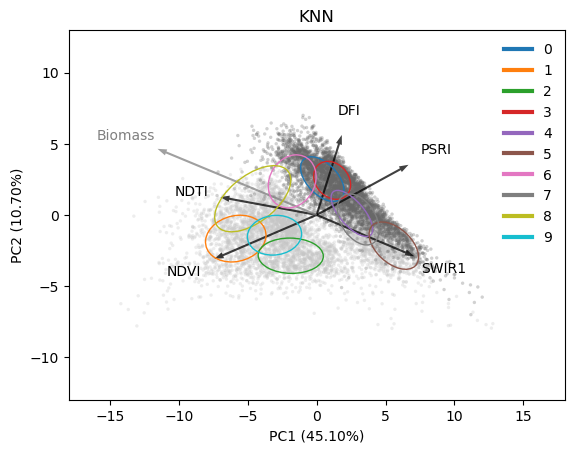

In [79]:
fig, ax = plt.subplots()
plot_pcs(df=df,
         ax=ax,
         var_names=var_names,
         pc_type = 'pls',
         var_reduce_type = 'manual',
         k=None,
         vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
         #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
         title='KNN',
         n_std=1.0,
         pcs=[1,2])
ax.set_xlim((-18, 18))
ax.set_ylim((-13, 13))